# Game Tweets

1. Load necessary libraries 
2. Load data into Jupyter Notebook 
3. Clean text  
    a. Remove emoji's   
    b. Remove weblinks  
    c. Remove hashtags  
    d. Remove usernames  
    e. Remove extra whitespace  
    f. Remove "RT"  
    g. Remove anything following "/" 
4. Add cleaned text (Step 3) to full dataframe 
5. Remove duplicate tweets using the cleaned text 
6. Create new dataframe that contains "game-like" tweets 
7. Create new dataframe that separates tweets by team (KS, TB) 
8. Sentiment analysis of  
    a. Cleaned full tweets  
    b. Cleaned game tweets  
    c. Cleaned team tweets
9. Data visualization for sentiment analysis      
    a. Distribution of polarity  
10. Use NLP and SpaCy to clean text   
    a. Full tweets  
    b. Game tweets  
    c. Team tweets
11. Word Clouds and counts for most positive and most negative polarity scores
12. DBSCAN Clustering  
    a. Perform on the two sets of data (full, game)  
    b. Determine Epsilon and Minimum number of Points in each cluster  
    c. Compute silhouette score to determine "optimal" eps and minPts  
    d. Plot clusters  
    e. Identify contents of each cluster  
    f. Performance metrics  


## 1. Load Libraries and MongoDB Data

In [1]:
#libraries

import pandas as pd #to create dataframe
from pymongo import MongoClient #load data from MongoDB
from pprint import pprint #print data from MongoDB
import re
import spacy
import nltk
import string #to remove punct and digits
import time #count the number of seconds that have passed
from collections import defaultdict #create dict to hold more than 1 value per key
import textblob #sentiment analysis
     
import matplotlib.pyplot as plt #generate a word cloud image and bar plots
from wordcloud import WordCloud
import seaborn as sns
from nltk import FreqDist #count top frequent words
import numpy as np
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer #create TD-IDF features
from sklearn import metrics #performance metrics

## 2. Load Game Tweets from MongoDB

In [2]:
#check that data was written to MongoDB
client = MongoClient()
db = client['Superbowl_2021']
tweets = db['Superbowl_tweets']

pprint(tweets.find_one())

client.close()

{'Date': 'Sun Jan 24 20:30:04 +0000 2021',
 'Hashtags': [],
 'Location': None,
 'Retweeted': False,
 'Time Zone': None,
 'Tweet': 'Tom Brady finally puts the ball downfield and throws three straight '
          'incompletions.',
 'User': 'Axoiry',
 '_id': ObjectId('600dd8d1132498eb08601609')}


In [3]:
tweets_df = pd.DataFrame(list(tweets.find())) #[1] convert mongoDB data to pandas dataframe
tweets_df.head()

,_id,Date,User,Tweet,Retweeted,Hashtags,Time Zone,Location
0,600dd8d1132498eb08601609,Sun Jan 24 20:30:04 +0000 2021,Axoiry,Tom Brady finally puts the ball downfield and ...,False,[],None,None
1,600dd8d1132498eb0860160a,Sun Jan 24 20:30:04 +0000 2021,MaistEta,@WHXMAS @packers @KCBoutThatLife horrible acco...,False,[],None,None
2,600dd8d1132498eb0860160b,Sun Jan 24 20:30:04 +0000 2021,the_tynasty,RT @stoolpresidente: Tom Brady is god. Im a d...,False,[],None,None
3,600dd8d1132498eb0860160c,Sun Jan 24 20:30:04 +0000 2021,Blase_J,RT @MrMola_: Bucs O-Line giving Brady a pocket...,False,[],None,"Oklahoma City, OK"
4,600dd8d1132498eb0860160d,Sun Jan 24 20:30:04 +0000 2021,Keegan_bergsiek,RT @CantGuardDarwin: Am I the only Chiefs fan ...,False,[],None,"Kansas City, MO"


In [4]:
tweets_df.shape #dimensions of tweets_df

(189284, 8)

In [5]:
tweets_df.columns #column names

Index(['_id', 'Date', 'User', 'Tweet', 'Retweeted', 'Hashtags', 'Time Zone',
       'Location'],
      dtype='object')

In [6]:
tweets_df["Tweet"].iloc[0:10] #look at first 10 "Tweet"

0    Tom Brady finally puts the ball downfield and ...
1    @WHXMAS @packers @KCBoutThatLife horrible acco...
2    RT @stoolpresidente: Tom Brady is god.  Im a d...
3    RT @MrMola_: Bucs O-Line giving Brady a pocket...
4    RT @CantGuardDarwin: Am I the only Chiefs fan ...
5    RT @thecheckdown: Blocking was great and Godwi...
6                    RT @Moneyflows: @BCOOL333 Packers
7    RT @DevinDae1: Hitting the “we lost” at the fi...
8    RT @LilySZhao: Kenny Clark. SACK. The #Packers...
9                    Ayo Tom Brady can suck my cock fr
Name: Tweet, dtype: object

## 3. Clean Text Using `RegEx`

*This includes removing emojis, weblinks, usernames, extra whitespace, and any other unnecessary characters*

In [7]:
count = 0 
for tweet in tweets_df["Tweet"]:
    if count <=20: # view first 20 tweets (before cleaning)
        print(count, tweet)
        count = count + 1

0 Tom Brady finally puts the ball downfield and throws three straight incompletions.
1 @WHXMAS @packers @KCBoutThatLife horrible account + ratio + 0 people asked
2 RT @stoolpresidente: Tom Brady is god.  Im a dummy
3 RT @MrMola_: Bucs O-Line giving Brady a pocket that’s cleaner than SW coochie (my bro said its clean)
4 RT @CantGuardDarwin: Am I the only Chiefs fan rooting for the Bucs? 
Reason: I want Mahomes to beat Brady in the SB and have a “passing dow…
5 RT @thecheckdown: Blocking was great and Godwin got the first 👀 @CGtwelve_ @Buccaneers 

📺 #TBvsGB on FOX https://t.co/1lcCSX760O
6 RT @Moneyflows: @BCOOL333 Packers
7 RT @DevinDae1: Hitting the “we lost” at the first sign of adversity &gt;&gt;&gt;&gt;
8 RT @LilySZhao: Kenny Clark. SACK. The #Packers needed that one.
9 Ayo Tom Brady can suck my cock fr
10 @andymeadchef In Spanish they're just discussing Brady going to the superbowl again
11 RT @packers: SACK! 

@KCBoutThatLife brings down Brady! 

#TBvsGB | #GoPackGo https://t.co/

In [8]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string) 

In [9]:
tweets_df["Tweet"][5]

'RT @thecheckdown: Blocking was great and Godwin got the first 👀 @CGtwelve_ @Buccaneers \n\n📺 #TBvsGB on FOX https://t.co/1lcCSX760O'

In [10]:
remove_emoji(tweets_df["Tweet"][5]) #apply function above to fifth tweet

'RT @thecheckdown: Blocking was great and Godwin got the first  @CGtwelve_ @Buccaneers \n\n #TBvsGB on FOX https://t.co/1lcCSX760O'

In [11]:
no_emoji = tweets_df["Tweet"].apply(remove_emoji) #apply function above to all tweets

In [12]:
#search for weblinks in `no_emoji` tweets

counter = 0
count = 0
for x in no_emoji:
    if re.search('http://\S+', x) and counter <=5: 
        counter = counter + 1
        print(counter, x)
    if re.search('https://\S+', x) and count <=5:
        count = count + 1
        print(count, x)

1 RT @thecheckdown: Blocking was great and Godwin got the first  @CGtwelve_ @Buccaneers 

 #TBvsGB on FOX https://t.co/1lcCSX760O
2 RT @packers: SACK! 

@KCBoutThatLife brings down Brady! 

#TBvsGB | #GoPackGo https://t.co/YCNNREbh5q
3 #TBvsGB 1 hand on him, Brady crumples to the turf for a sack https://t.co/Sxu6P40ZJc
4 Lead us not only into Greenbay, but deliver us back to Tampabay. For thine is the GOAT, the best of the NFC, and th… https://t.co/CxPWVV8aMo
5 1/24 NFL Conference Championship Sunday Part 1:

NFC Championship up first. Tampa Bay strikes first and leads Green… https://t.co/mcrB7GIrBg
6 RT @KingJosiah54: When Brady and Rodgers see each other at the NFC Championship https://t.co/SL8Z1YPFmF
1 RT @ProFootballTalk: Tom Brady could be sliding out of the league's elite quarterbacks http://is.gd/5l7aY #NFL
2 RT @BleacherReport: Aaron Rodgers on gay rumors: "I'm not gay. I really, really like women." http://t.co/VfxYstSpFO
3 RT @BleacherReport: Aaron Rodgers on gay rumors: "I'm 

In [13]:
#remove http://, \S is anything that is not a space
no_html_tweets = no_emoji.apply(lambda x: re.sub('http://\S+', '', x))

In [14]:
#remove https://
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('https://\S+', '', x))

In [15]:
#remove @usernames
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('@\S+', '', x))

In [16]:
#remove #hashtags
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('#\S+', '', x))

In [17]:
#Remove RT
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('RT', '', x))

In [18]:
#remove /
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('/\S+', '', x))

In [19]:
#remove extra whitespace
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('\s\s+', ' ', x))

In [20]:
no_html_tweets.iloc[0:10] #print first 10 cleaned tweets

0    Tom Brady finally puts the ball downfield and ...
1            horrible account + ratio + 0 people asked
2                         Tom Brady is god. Im a dummy
3     Bucs O-Line giving Brady a pocket that’s clea...
4     Am I the only Chiefs fan rooting for the Bucs...
5     Blocking was great and Godwin got the first o...
6                                              Packers
7     Hitting the “we lost” at the first sign of ad...
8              Kenny Clark. SACK. The needed that one.
9                    Ayo Tom Brady can suck my cock fr
Name: Tweet, dtype: object

In [21]:
#print cleaned and original tweets
print("Original Tweets: \n")
count = 0 
for tweet in tweets_df["Tweet"]:
    if count <=20: # view first 20 tweets (before cleaning)
        print(count, tweet)
        count = count + 1
print("\n")
print("Cleaned Tweets: \n")
count = 0
for tweet in no_html_tweets:
    if count <=20: # view first 20 tweets (after cleaning)
        print(count, tweet)
        count = count + 1

Original Tweets: 

0 Tom Brady finally puts the ball downfield and throws three straight incompletions.
1 @WHXMAS @packers @KCBoutThatLife horrible account + ratio + 0 people asked
2 RT @stoolpresidente: Tom Brady is god.  Im a dummy
3 RT @MrMola_: Bucs O-Line giving Brady a pocket that’s cleaner than SW coochie (my bro said its clean)
4 RT @CantGuardDarwin: Am I the only Chiefs fan rooting for the Bucs? 
Reason: I want Mahomes to beat Brady in the SB and have a “passing dow…
5 RT @thecheckdown: Blocking was great and Godwin got the first 👀 @CGtwelve_ @Buccaneers 

📺 #TBvsGB on FOX https://t.co/1lcCSX760O
6 RT @Moneyflows: @BCOOL333 Packers
7 RT @DevinDae1: Hitting the “we lost” at the first sign of adversity &gt;&gt;&gt;&gt;
8 RT @LilySZhao: Kenny Clark. SACK. The #Packers needed that one.
9 Ayo Tom Brady can suck my cock fr
10 @andymeadchef In Spanish they're just discussing Brady going to the superbowl again
11 RT @packers: SACK! 

@KCBoutThatLife brings down Brady! 

#TBvsGB | #GoP

## 4. Add Cleaned Tweets to Dataframe

In [22]:
type(no_html_tweets)

pandas.core.series.Series

In [23]:
tweets_df["Clean Tweets"] = no_html_tweets
tweets_df.columns

Index(['_id', 'Date', 'User', 'Tweet', 'Retweeted', 'Hashtags', 'Time Zone',
       'Location', 'Clean Tweets'],
      dtype='object')

In [24]:
tweets_df.head()

,_id,Date,User,Tweet,Retweeted,Hashtags,Time Zone,Location,Clean Tweets
0,600dd8d1132498eb08601609,Sun Jan 24 20:30:04 +0000 2021,Axoiry,Tom Brady finally puts the ball downfield and ...,False,[],None,None,Tom Brady finally puts the ball downfield and ...
1,600dd8d1132498eb0860160a,Sun Jan 24 20:30:04 +0000 2021,MaistEta,@WHXMAS @packers @KCBoutThatLife horrible acco...,False,[],None,None,horrible account + ratio + 0 people asked
2,600dd8d1132498eb0860160b,Sun Jan 24 20:30:04 +0000 2021,the_tynasty,RT @stoolpresidente: Tom Brady is god. Im a d...,False,[],None,None,Tom Brady is god. Im a dummy
3,600dd8d1132498eb0860160c,Sun Jan 24 20:30:04 +0000 2021,Blase_J,RT @MrMola_: Bucs O-Line giving Brady a pocket...,False,[],None,"Oklahoma City, OK",Bucs O-Line giving Brady a pocket that’s clea...
4,600dd8d1132498eb0860160d,Sun Jan 24 20:30:04 +0000 2021,Keegan_bergsiek,RT @CantGuardDarwin: Am I the only Chiefs fan ...,False,[],None,"Kansas City, MO",Am I the only Chiefs fan rooting for the Bucs...


## 5. Remove Duplicate Tweets

In [25]:
clean_tweets_df = tweets_df.drop_duplicates(subset=['Clean Tweets'])
clean_tweets_df.shape, tweets_df.shape

((125772, 9), (189284, 9))

In [26]:
clean_tweets_df = clean_tweets_df.reset_index(drop=True) 

## 6. Filter "Game-Like" Tweets

In [27]:
values = ["redzone", "ball", "incompletion", "interception", "throw", 
        "catch", "downfield", "oline", "offensive", "defensive", 
       "offense", "defense", "blocking", "block", "win", "lose", "sack", "superbowl",
       "score", "home", "away", "goat", "1st", "2nd", "3rd", "4th", "down", "td", "int", "touchdown", 
        "root", "stop", "pass", "rush", "play", "Tom Brady", "Patrick Mahomes", "Bucs", "Buccaneers", 
          "Gronk", "Gronkowski", "Brady", "TB", "Antonio Brown", "Chiefs", "Kansas City",
          "Travis Kelce", "Kelce", "Mahomes", "KC", "tackle", "offsides", "end zone", "block", "fair", "catch", 
          "field goal", "fumble", "grounding", "neutral", "pocket", "safety", "turnover", "zone", "snap"]

tweet_dict = defaultdict(list)  #dict = key:[val, val,..]

for key in clean_tweets_df["Clean Tweets"]:
    for val in values:
        match = re.search(val, key)
        if match:
            tweet_dict[key].append(val)

In [28]:
len(tweet_dict)

63598

In [29]:
game_tweets = pd.DataFrame(list(tweet_dict.items()), columns=["Tweet", "Keywords"]) 
game_tweets.head()

,Tweet,Keywords
0,Tom Brady finally puts the ball downfield and ...,"[ball, incompletion, throw, downfield, down, T..."
1,Tom Brady is god. Im a dummy,"[Tom Brady, Brady]"
2,Bucs O-Line giving Brady a pocket that’s clea...,"[Bucs, Brady, pocket]"
3,Am I the only Chiefs fan rooting for the Bucs...,"[home, root, pass, Bucs, Brady, Chiefs, Mahomes]"
4,Blocking was great and Godwin got the first o...,[win]


## 7. Separate Tweets by Team

In [30]:
# Kansas City Chiefs Tweets

chiefs_keys = ["Patrick Mahomes", "Chiefs", "Kansas City", "Travis Kelce", "Kelce", "Mahomes", "KC", 
"Tyrann Mathieu", "Tyrann", "Mathieu", "Tyreek Hill"]
chiefs = []

for tweet in clean_tweets_df["Clean Tweets"]:
    for key in chiefs_keys:
        if key in tweet and tweet not in chiefs:
            chiefs.append(tweet)
len(chiefs)

13463

In [31]:
# Tampa Bay Buccaneers Tweets

bucs_keys = ["Tom Brady", "Bucs", "Buccaneers", "Gronk", "Gronkowski", "Brady", "TB", "Antonio Brown",
             "Godwin"]
bucs = []

for tweet in clean_tweets_df["Clean Tweets"]:
    for key in bucs_keys:
        if key in tweet and tweet not in bucs:
            bucs.append(tweet)
len(bucs)

21022

## 8. Sentiment Analysis Using `Textblob`

### A. Sentiment Analysis of Full Dataset

In [32]:
tb_0 = textblob.TextBlob(clean_tweets_df["Clean Tweets"][0]) #apply textblob to first tweet

In [33]:
tb_0.sentiment #look at sentiment of first tweet

Sentiment(polarity=0.1, subjectivity=0.7)

In [34]:
tb_0.correct(), tb_0.correct().sentiment #correct spelling of first tweet

(TextBlob("Tom Grady finally puts the ball cornfield and throws three straight incompletions."),
 Sentiment(polarity=0.1, subjectivity=0.7))

In [35]:
tb_0.sentiment_assessments #view sentiment assessments of  first tweet

Sentiment(polarity=0.1, subjectivity=0.7, assessments=[(['finally'], 0.0, 1.0, None), (['straight'], 0.2, 0.4, None)])

In [36]:
full_tb_sentiment_assessments = {} #add sentiment assessments of all tweets to dict

start = time.time()
for r in range(0, len(clean_tweets_df["Clean Tweets"])):
    full_tb_sentiment_assessments[clean_tweets_df["Clean Tweets"][r]] = textblob.TextBlob(clean_tweets_df["Clean Tweets"][r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')



Process took 60 seconds


Can use function below to collect sentiment assessments

In [37]:
# def textblob_sentiments(text, sentiment_dict, keys_list, polarity_list, subj_list, assess_list):
    
# # text is the tweets to be analyzed
# # sentiment_dict is an empty dict 
# # keys_list, polarity_list, subj_list, assess_list are empty lists

#     print("Adding sentiments tuple to dictionary...")
    
#     start = time.time()
#     for r in range(0, len(text)):
#         sentiment_dict[text[r]] = textblob.TextBlob(text[r]).sentiment_assessments 
#         #calculate sentiment assessments and add them to empty dictionary (tweet:sentiment assessments tuple)
    
#     end = time.time()
#     print('Process took', int(round(end - start)), 'seconds') #count number of seconds that it takes to process code above 
    
#     print("Creating new dataframe...")
    
#     for key, value in sentiment_dict.items():
#         keys_list.append(key) #get tweets
#         value_list = list(value) #get sentiment assessments in a list
#         polarity_list.append(value_list[0]) #get polarity scores
#         subj_list.append(value_list[1]) #get subjectivity scores
#         assess_list.append(value_list[2]) #get assessments 
        
#     print("Last step...")
    
#     new_df = pd.DataFrame(zip(text, polarity_list, subj_list, assess_list), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments']) #create new dataframe using lists above
#     return(new_df)

In [38]:
# test_dict = {} #dictionary to calculate and contain sentment assessments
# keys = [] #get keys (tweets) from test_dict
# polarity = [] #get polarity scores
# subjectivity = [] #get subjectivity scores
# assessments = [] #get assessments

# assessments_df = textblob_sentiments(clean_tweets_df["Clean Tweets"], test_dict, keys, polarity, subjectivity, assessments) #apply function above

# assessments_df.head() #check to make sure data was collected correctly

In [39]:
print('There are {} tweets that TextBlob was unable to process.'.format(len(clean_tweets_df["Clean Tweets"])-len(full_tb_sentiment_assessments)))
#view number of tweets that TextBlob was unable to process

There are 0 tweets that TextBlob was unable to process.


In [40]:
list(full_tb_sentiment_assessments.keys())[0], list(full_tb_sentiment_assessments.values())[0]
#view first key (tweet) and first value (sentiment assessments) in dict

('Tom Brady finally puts the ball downfield and throws three straight incompletions.',
 Sentiment(polarity=0.1, subjectivity=0.7, assessments=[(['finally'], 0.0, 1.0, None), (['straight'], 0.2, 0.4, None)]))

In [41]:
x = list(full_tb_sentiment_assessments.values())[0] #list format for first value
x

Sentiment(polarity=0.1, subjectivity=0.7, assessments=[(['finally'], 0.0, 1.0, None), (['straight'], 0.2, 0.4, None)])

In [42]:
x[0], x[1], x[2] #polarity,subjectivity, assessments 

(0.1, 0.7, [(['finally'], 0.0, 1.0, None), (['straight'], 0.2, 0.4, None)])

In [43]:
#separate keys and values into their own lists

keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in full_tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])


In [44]:
keys[0], polarity[0], subjectivity[0], assessments[0] #ensure keys and values are ordered properly

('Tom Brady finally puts the ball downfield and throws three straight incompletions.',
 0.1,
 0.7,
 [(['finally'], 0.0, 1.0, None), (['straight'], 0.2, 0.4, None)])

In [45]:
full_assessments_df = pd.DataFrame(zip(clean_tweets_df["Clean Tweets"], polarity, subjectivity, assessments), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments'])
full_assessments_df.head(5) #create new dataframe for tweets and their assements

,Tweet,Polarity,Subjectivity,Assessments
0,Tom Brady finally puts the ball downfield and ...,0.100000,0.7,"[([finally], 0.0, 1.0, None), ([straight], 0.2..."
1,horrible account + ratio + 0 people asked,-1.000000,1.0,"[([horrible], -1.0, 1.0, None)]"
2,Tom Brady is god. Im a dummy,0.000000,0.0,[]
3,Bucs O-Line giving Brady a pocket that’s clea...,0.366667,0.7,"[([clean], 0.3666666666666667, 0.7000000000000..."
4,Am I the only Chiefs fan rooting for the Bucs...,0.000000,1.0,"[([only], 0.0, 1.0, None)]"


In [144]:
full_assessments_df["Polarity"].mean()

0.06390615446119964

In [155]:
full_assessments_df["Polarity"].round(0).value_counts()

 0.0    110917
 1.0     10520
-1.0      4335
Name: Polarity, dtype: int64

### B. Sentiment Analysis of Game-Like Data

In [46]:
tb_sentiment_assessments = {}

start = time.time()
for r in range(0, len(game_tweets["Tweet"])):
    tb_sentiment_assessments[game_tweets["Tweet"][r]]= textblob.TextBlob(game_tweets["Tweet"][r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')


Process took 32 seconds


In [47]:
print('There are {} tweets that TextBlob was unable to process.'.format(len(game_tweets["Tweet"])-len(tb_sentiment_assessments)))

There are 0 tweets that TextBlob was unable to process.


In [48]:
keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])


In [49]:
keys[0], polarity[0], subjectivity[0], assessments[0]

('Tom Brady finally puts the ball downfield and throws three straight incompletions.',
 0.1,
 0.7,
 [(['finally'], 0.0, 1.0, None), (['straight'], 0.2, 0.4, None)])

In [50]:
assessments_df = pd.DataFrame(zip(game_tweets["Tweet"], game_tweets["Keywords"], polarity, subjectivity, assessments), columns=['Tweet', 'Keywords', 'Polarity', 'Subjectivity','Assessments'])
assessments_df.head(5)

,Tweet,Keywords,Polarity,Subjectivity,Assessments
0,Tom Brady finally puts the ball downfield and ...,"[ball, incompletion, throw, downfield, down, T...",0.100000,0.700000,"[([finally], 0.0, 1.0, None), ([straight], 0.2..."
1,Tom Brady is god. Im a dummy,"[Tom Brady, Brady]",0.000000,0.000000,[]
2,Bucs O-Line giving Brady a pocket that’s clea...,"[Bucs, Brady, pocket]",0.366667,0.700000,"[([clean], 0.3666666666666667, 0.7000000000000..."
3,Am I the only Chiefs fan rooting for the Bucs...,"[home, root, pass, Bucs, Brady, Chiefs, Mahomes]",0.000000,1.000000,"[([only], 0.0, 1.0, None)]"
4,Blocking was great and Godwin got the first o...,[win],0.525000,0.541667,"[([great], 0.8, 0.75, None), ([first], 0.25, 0..."


In [156]:
assessments_df["Polarity"].mean()

0.08417414956699919

In [157]:
assessments_df["Polarity"].round(0).value_counts()

 0.0    55687
 1.0     6019
-1.0     1892
Name: Polarity, dtype: int64

### C. Sentiment Analysis of Team Data

#### Kansas City Chiefs

In [51]:
chiefs_tb_sentiment_assessments = {}

start = time.time()
for r in range(0, len(chiefs)):
    chiefs_tb_sentiment_assessments[chiefs[r]]= textblob.TextBlob(chiefs[r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')


Process took 8 seconds


In [52]:
keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in chiefs_tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])

chiefs_assessments_df = pd.DataFrame(zip(chiefs,  polarity, subjectivity, assessments), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments'])
chiefs_assessments_df.head(5)

,Tweet,Polarity,Subjectivity,Assessments
0,Am I the only Chiefs fan rooting for the Bucs...,0.00,1.000,"[([only], 0.0, 1.0, None)]"
1,CHAMPIONSHIP SUNDAY - Bucs vs. Packers\n- Bil...,0.00,0.000,[]
2,Packers and Chiefs,0.00,0.000,[]
3,Bucs-Chiefs is my SB LV prediction. Who yall got?,0.00,0.000,[]
4,Bucks roster in 20 Chiefs roster 19 crazy... b...,-0.15,0.375,"[([crazy], -0.6, 0.9, None), ([back], 0.0, 0.0..."


In [53]:
chiefs_assessments_df['Polarity'].mean()

0.11906644963709229

In [158]:
chiefs_assessments_df['Polarity'].round(0).value_counts()

 0.0    11791
 1.0     1358
-1.0      314
Name: Polarity, dtype: int64

#### Tampa Bay Buccaneers

In [54]:
bucs_tb_sentiment_assessments = {}

start = time.time()
for r in range(0, len(bucs)):
    bucs_tb_sentiment_assessments[bucs[r]]= textblob.TextBlob(bucs[r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')


Process took 14 seconds


In [55]:
keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in bucs_tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])

bucs_assessments_df = pd.DataFrame(zip(bucs,  polarity, subjectivity, assessments), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments'])
bucs_assessments_df.head(5)

,Tweet,Polarity,Subjectivity,Assessments
0,Tom Brady finally puts the ball downfield and ...,0.100000,0.700000,"[([finally], 0.0, 1.0, None), ([straight], 0.2..."
1,Tom Brady is god. Im a dummy,0.000000,0.000000,[]
2,Bucs O-Line giving Brady a pocket that’s clea...,0.366667,0.700000,"[([clean], 0.3666666666666667, 0.7000000000000..."
3,Am I the only Chiefs fan rooting for the Bucs...,0.000000,1.000000,"[([only], 0.0, 1.0, None)]"
4,Blocking was great and Godwin got the first o...,0.525000,0.541667,"[([great], 0.8, 0.75, None), ([first], 0.25, 0..."


In [56]:
bucs_assessments_df['Polarity'].mean()

0.08228903675459934

In [159]:
bucs_assessments_df['Polarity'].round(0).value_counts()

 0.0    18596
 1.0     1796
-1.0      630
Name: Polarity, dtype: int64

## 9. Polarity Distributions of Sentiment Scores

In [151]:
#full_assessments_df['Polarity'].round(1).value_counts()

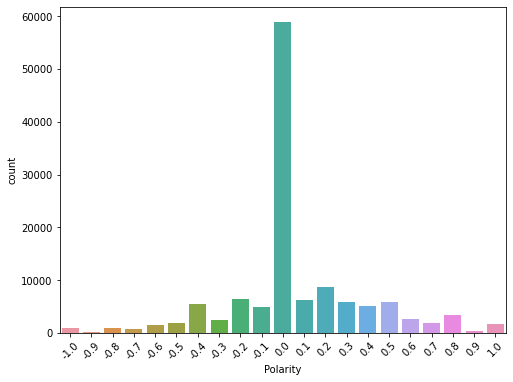

In [58]:
full_polarity = full_assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = full_polarity, data = full_assessments_df) #polarity distribution of full dataset (8.A) sentiments

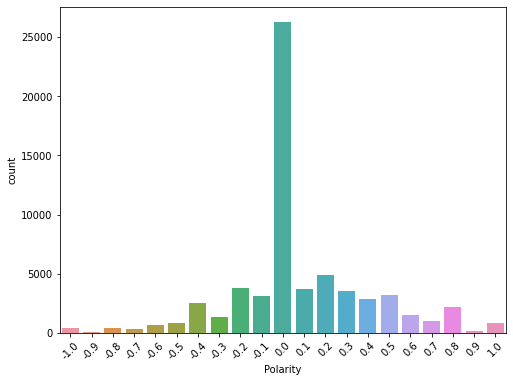

In [59]:
game_polarity = assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = game_polarity, data = assessments_df)  #polarity distribution of game-like data (8.B) sentiments

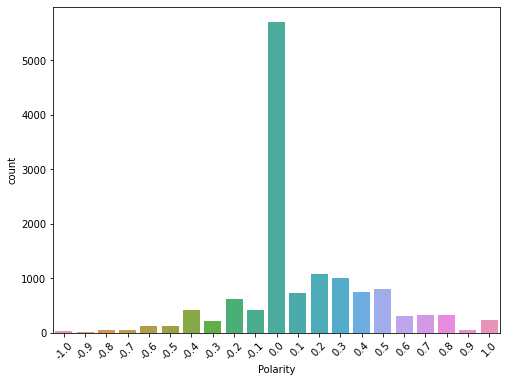

In [60]:
chiefs_polarity = chiefs_assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = chiefs_polarity, data = chiefs_assessments_df) #polarity distribution of Kansas City (8.C) sentiments

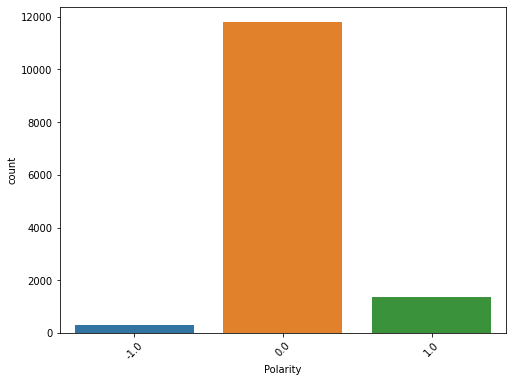

In [61]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = chiefs_assessments_df['Polarity'].round(0), data = chiefs_assessments_df) #polarity distribution of Kansas City (8.C) sentiments

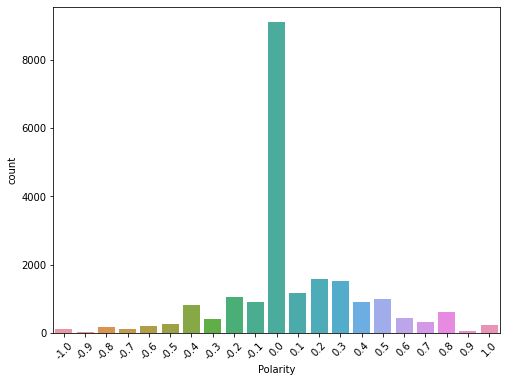

In [62]:
bucs_polarity = bucs_assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = bucs_polarity, data = bucs_assessments_df) #polarity distribution of Tampa Bay (8.C) sentiments

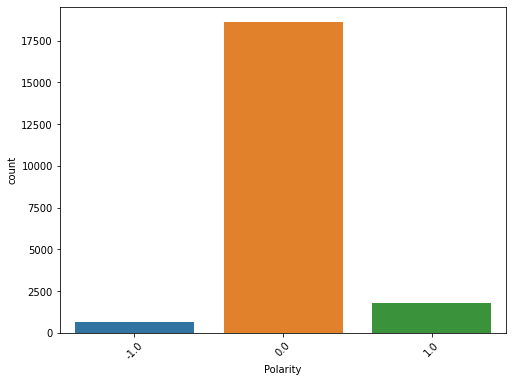

In [63]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = bucs_assessments_df['Polarity'].round(0), data = bucs_assessments_df) #polarity distribution of Tampa Bay (8.C) sentiments

## 10. Natural Language Processing Using `spaCy`

In [64]:
nlp = spacy.load('en_core_web_lg') #load English spaCy pipeline, large

In [65]:
stopwords = nltk.corpus.stopwords.words('english') #load nltk's English stopword list
stopwords[0:10] #view 10 stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [66]:
stopwords = set(stopwords + ['RT', 'DM', 'retweet',
                             'direct message', 'reply', 'following', 'followers', 
                             'mention', 'hashtag']) 
#adds to list of stopwords above and keep as set()

In [67]:
# simple clean text function -- spacy lowercases, removes stopwords, lemmatizes
    #function from Text Analytics Week 5 Assignment
    
def clean_text(docs):
    # remove punctuation and numbers
    # I do this before lemmatizing, so things like "act's" turn into 'act' instead of 'act s'
    print('removing punctuation and digits')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in docs]
    
    print('spacy nlp...longest part')
    nlp_docs = [nlp(d) for d in clean_docs]
    
    # keep the word if it's a pronoun, otherwise use the lemma
    # otherwise spacy substitutes '-PRON-' for pronouns
    print('getting lemmas')
    lemmatized_docs = [[w.lemma_ if w.lemma_ != '-PRON-'
                           else w.lower_
                           for w in d]
                      for d in nlp_docs]
    
    # remove stopwords
    print('removing stopwords')
    lemmatized_docs = [[lemma for lemma in doc if lemma not in stopwords] for doc in lemmatized_docs] 

        #remove specific stop words
    
    # join tokens back into doc (string) because lemmatized_docs is a list
    clean_docs = [' '.join(l) for l in lemmatized_docs] #join tweets in a string
        
    return clean_docs

### A. Clean Full Dataset using NLP

In [68]:
start = time.time()
full_clean_tweets = clean_text(full_assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 760 seconds


In [69]:
full_clean_tweets[0], full_assessments_df["Tweet"][0] #nlp cleaned tweets vs ReGex cleaned tweets

('Tom Brady finally put ball downfield throw three straight incompletion',
 'Tom Brady finally puts the ball downfield and throws three straight incompletions.')

In [70]:
len(full_clean_tweets), full_assessments_df.shape #match length of nlp tweets to length of dataframe

(125772, (125772, 4))

In [71]:
full_assessments_df["UDF Clean Tweets"] = full_clean_tweets

### B. Clean Game-Like Dataset using NLP

In [72]:
start = time.time()
clean_tweets = clean_text(assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 396 seconds


In [73]:
len(clean_tweets), assessments_df.shape #match length of nlp tweets to length of dataframe

(63598, (63598, 5))

In [74]:
assessments_df["UDF Clean Tweets"] = clean_tweets

### C. Clean Team Datasets using NLP

#### Kansas City Chiefs

In [75]:
start = time.time()
chiefs_clean_tweets = clean_text(chiefs_assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 81 seconds


In [76]:
len(chiefs_clean_tweets), chiefs_assessments_df.shape #match length of nlp tweets to length of dataframe

(13463, (13463, 4))

In [77]:
chiefs_assessments_df["UDF Clean Tweets"] = chiefs_clean_tweets

#### Tampa Bay Buccaneers

In [78]:
start = time.time()
bucs_clean_tweets = clean_text(bucs_assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 137 seconds


In [79]:
len(bucs_clean_tweets), bucs_assessments_df.shape #match length of nlp tweets to length of dataframe

(21022, (21022, 4))

In [80]:
bucs_assessments_df["UDF Clean Tweets"] = bucs_clean_tweets

## 11. Word Clouds

### A. Full Dataset Word Clouds

In [81]:
tweets_string = ' '.join(full_clean_tweets)
tweets_fd = FreqDist(tweets_string.split())
tweets_fd.most_common(20)

[('…', 18626),
 ('Allen', 14518),
 ('Josh', 13809),
 ('go', 13272),
 ('get', 12906),
 ('game', 11063),
 ('Brady', 11023),
 ('Bucs', 8679),
 ('packer', 8553),
 ('Packers', 7776),
 ('Tom', 7205),
 ('play', 6974),
 ('Mahomes', 6891),
 ('like', 6833),
 ('’', 6778),
 ('Rodgers', 6150),
 ('win', 6096),
 ('good', 5808),
 ('bill', 4827),
 ('Patrick', 4692)]

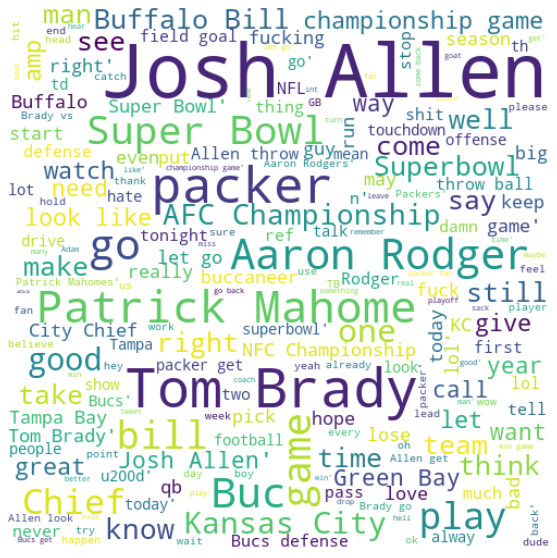

In [82]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(full_clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [83]:
#top polarity values
full_assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
115961,offsetting penalties !!!!!🤣 Awesome refs,1.0,1.000000,"[([awesome], 1.0, 1.0, None)]",offset penalty 🤣 Awesome ref
3639,I pray that Tom Brady Buccaneers win this game...,1.0,0.400000,"[([win, !], 1.0, 0.4, None)]",pray Tom Brady Buccaneers win game go superbow...
105103,Great job with the pick!,1.0,0.750000,"[([great, !], 1.0, 0.75, None)]",great job pick
82766,Josh Allen. Best ever. Heard about it.,1.0,0.300000,"[([best], 1.0, 0.3, None)]",Josh Allen Best ever hear
82747,Awesome,1.0,1.000000,"[([awesome], 1.0, 1.0, None)]",Awesome
82743,another field goal! This is where the best pla...,1.0,0.300000,"[([best, !], 1.0, 0.3, None)]",another field goal good player world lead driv...
43614,I fucking love DAVANTE ADAMS!!!!!,1.0,0.600000,"[([fucking, love, !, !, !, !, !], 1.0, 0.6, No...",fucking love DAVANTE ADAMS
82726,Bills and Bucs 2018 trade where they got Josh...,1.0,0.750000,"[([great, !], 1.0, 0.75, None)]",Bills Bucs trade get Josh Allen get Vita V...
105156,Lol yes!!!!,1.0,0.700000,"[([lol, !, !, !, !], 1.0, 0.7, None)]",lol yes
118151,We went into everyone’s house and showed them ...,1.0,0.500000,"[([better, !, !, !, !], 1.0, 0.5, None)]",go everyone ’s house show well ’ go cray see …


In [84]:
top_polar = full_assessments_df.loc[full_assessments_df['Polarity'] >= 0.01]
top_tweets_string = ' '.join(top_polar["UDF Clean Tweets"])
top_tweets_fd = FreqDist(top_tweets_string.split())
top_tweets_fd.most_common(20)

[('…', 9241),
 ('win', 5508),
 ('good', 5382),
 ('Allen', 5137),
 ('Josh', 4870),
 ('go', 4855),
 ('Brady', 4732),
 ('get', 4618),
 ('Bucs', 3240),
 ('Mahomes', 3186),
 ('game', 3171),
 ('Tom', 3085),
 ('Super', 2907),
 ('’', 2833),
 ('play', 2818),
 ('Packers', 2793),
 ('packer', 2695),
 ('Bowl', 2649),
 ('like', 2447),
 ('great', 2430)]

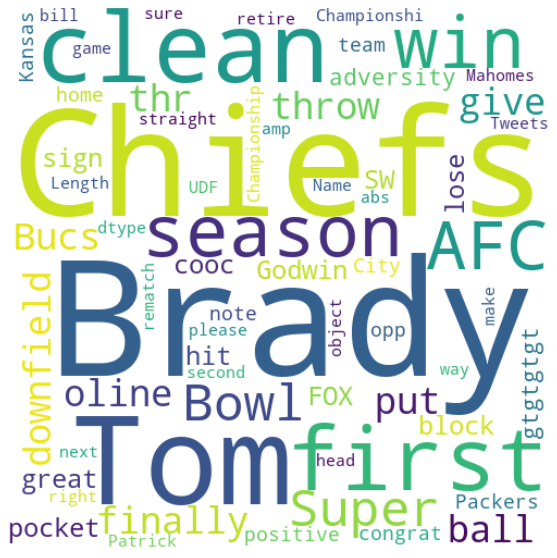

In [85]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [86]:
#lowest polarity values
full_assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
104707,josh allen is awful,-1.0,1.0,"[([awful], -1.0, 1.0, None)]",josh allen awful
57967,Me watching the Packers every week. The worst ...,-1.0,1.0,"[([worst], -1.0, 1.0, None)]",watch Packers every week bad relationship sport
110748,Josh Allen after taking another terrible sack.,-1.0,1.0,"[([terrible], -1.0, 1.0, None)]",Josh Allen take another terrible sack
16676,Let's see if the Packers defense can stop bein...,-1.0,1.0,"[([pathetic], -1.0, 1.0, None)]",lets see Packers defense stop pathetic
93354,I knew this was very stupid when I saw it. Let...,-1.0,1.0,"[([very, stupid], -1.0, 1.0, None)]",know stupid see let ’s see explain tomorrow
83045,I hate him with all I have. Go AFC!,-1.0,0.9,"[([hate, !], -1.0, 0.9, None)]",hate Go AFC
55834,I like the Packers because I think NFL team o...,-1.0,1.0,"[([universally, terrible], -1.0, 1.0, None)]",like Packers think NFL team owner almost uni...
101112,i just know abel is going to give an insane pe...,-1.0,1.0,"[([insane], -1.0, 1.0, None)]",know abel go give insane performance superbowl...
65683,Josh Allen is making some really awful decisio...,-1.0,1.0,"[([really, awful], -1.0, 1.0, None)]",Josh Allen make really awful decision tonight
119210,"""One team knows their season is ending and the...",-1.0,1.0,"[([worst], -1.0, 1.0, None)]",one team know season end take bad way well say


In [87]:
low_polar = full_assessments_df.loc[full_assessments_df['Polarity'] <= -0.01]
low_tweets_string = ' '.join(low_polar["UDF Clean Tweets"])
low_tweets_fd = FreqDist(low_tweets_string.split())
low_tweets_fd.most_common(20)

[('game', 7380),
 ('…', 4854),
 ('get', 3312),
 ('Allen', 3310),
 ('Josh', 3107),
 ('go', 2889),
 ('Packers', 2250),
 ('Brady', 2243),
 ('packer', 2081),
 ('Bucs', 1872),
 ('play', 1813),
 ('’', 1762),
 ('like', 1623),
 ('bad', 1611),
 ('Tom', 1481),
 ('Rodgers', 1364),
 ('bill', 1099),
 ('fuck', 1071),
 ('make', 1053),
 ('Mahomes', 1026)]

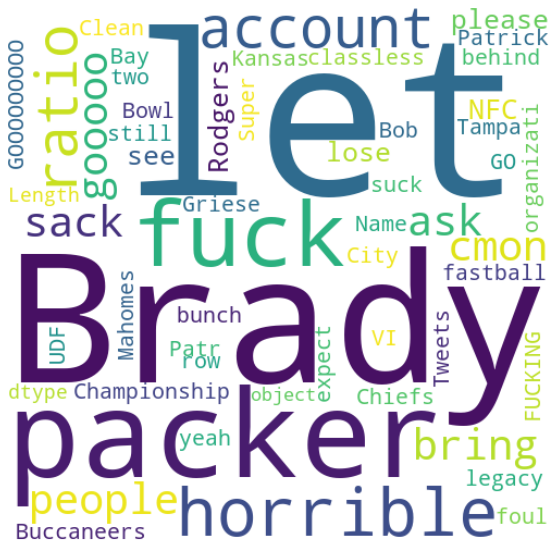

In [88]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

### B. Game-Like Word Clouds

In [89]:
game_tweets_string = ' '.join(clean_tweets)
game_tweets_fd = FreqDist(game_tweets_string.split())
game_tweets_fd.most_common(20)

[('…', 12333),
 ('Brady', 11023),
 ('Bucs', 8673),
 ('get', 7715),
 ('go', 7529),
 ('Tom', 6941),
 ('Mahomes', 6891),
 ('play', 6797),
 ('Allen', 6725),
 ('game', 6470),
 ('Josh', 6317),
 ('win', 5754),
 ('Packers', 4610),
 ('Patrick', 4576),
 ('Chiefs', 4334),
 ('packer', 4053),
 ('like', 3907),
 ('’', 3719),
 ('defense', 3517),
 ('Rodgers', 3432)]

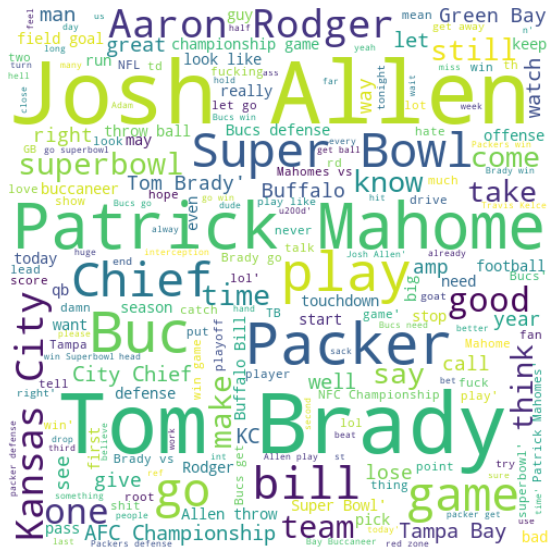

In [90]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [91]:
#top polarity values
assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Keywords,Polarity,Subjectivity,Assessments,UDF Clean Tweets
41299,Best defensive performance by a DB ever,[defensive],1.0,0.300000,"[([best], 1.0, 0.3, None)]",good defensive performance DB ever
27971,Tom Brady and Aaron Rodgers just continue to a...,"[Tom Brady, Brady]",1.0,1.000000,"[([greatest], 1.0, 1.0, None)]",Tom Brady Aaron Rodgers continue amaze two gre...
40388,Or Patrick Mahomes is the best player in the nfl,"[home, play, Patrick Mahomes, Mahomes]",1.0,0.300000,"[([best], 1.0, 0.3, None)]",Patrick Mahomes good player nfl
50026,"If Brady beats Brees, Rodgers, and Mahomes in ...","[home, play, Brady, Mahomes]",1.0,1.000000,"[([greatest], 1.0, 1.0, None)]",Brady beat Brees Rodgers Mahomes one playoff r...
25721,It’s going to be one of those games.....toooo...,[lose],1.0,0.400000,"[([win, !, !, !, !], 1.0, 0.4, None)]",’ go one gamestooooo close \n still say BUCS...
12527,Packers have the best offense in the league s...,"[offense, stop, Bucs]",1.0,0.300000,"[([best], 1.0, 0.3, None)]",Packers good offense league statistically Bu...
27898,Bucs got excellent field position.,[Bucs],1.0,1.000000,"[([excellent], 1.0, 1.0, None)]",Bucs get excellent field position
62785,This will be the best superbowl in years!,[superbowl],1.0,0.300000,"[([best, !], 1.0, 0.3, None)]",good superbowl year
25740,A 28-10 Bucs blown lead here would be the bes...,[Bucs],1.0,0.300000,"[([best], 1.0, 0.3, None)]",Bucs blow lead would good thing ever
55357,Great year to the Buffalo Bills!!! Daboll wher...,"[int, play]",1.0,0.750000,"[([great, !, !, !], 1.0, 0.75, None)]",great year Buffalo Bills Daboll head motion se...


In [92]:
game_top_polar = assessments_df.loc[assessments_df['Polarity'] >= 0.01]
game_top_tweets_string = ' '.join(game_top_polar["UDF Clean Tweets"])
game_top_tweets_fd = FreqDist(game_top_tweets_string.split())
game_top_tweets_fd.most_common(20)

[('…', 6202),
 ('win', 5275),
 ('Brady', 4732),
 ('Bucs', 3239),
 ('Mahomes', 3186),
 ('go', 3173),
 ('good', 3072),
 ('Tom', 2998),
 ('get', 2959),
 ('play', 2754),
 ('Allen', 2649),
 ('Josh', 2492),
 ('game', 2108),
 ('Super', 2090),
 ('Patrick', 2087),
 ('Chiefs', 1932),
 ('Bowl', 1899),
 ('Packers', 1832),
 ('’', 1668),
 ('packer', 1609)]

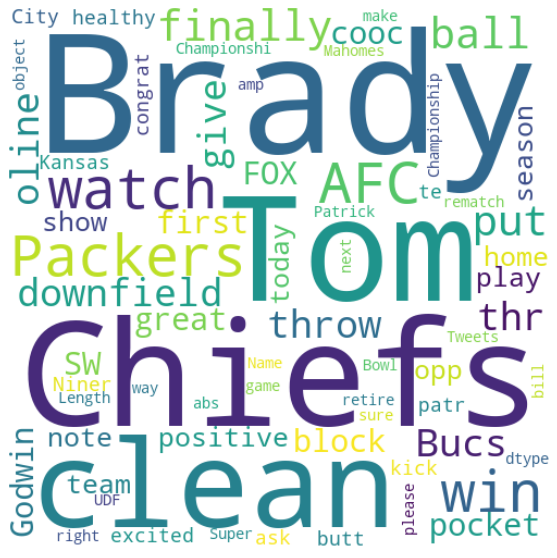

In [93]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(game_top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [94]:
#lowest polarity values
assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Keywords,Polarity,Subjectivity,Assessments,UDF Clean Tweets
15832,Packers DB have terrible ball tracking skills,[ball],-1.0,1.0,"[([terrible], -1.0, 1.0, None)]",packer DB terrible ball tracking skill
35131,Damn terrible pass by Josh Allen,[pass],-1.0,1.0,"[([terrible], -1.0, 1.0, None)]",damn terrible pass Josh Allen
29018,After how horrible this has gone.... the Packe...,[away],-1.0,1.0,"[([horrible], -1.0, 1.0, None)]",horrible go Packers drop surefire td Davante a...
23658,And we have a ball game.... 28-24 Bucs. 4th qu...,"[ball, 4th, Bucs]",-1.0,0.4,"[([game, !, !, !, !, !], -1.0, 0.4, None)]",ball game Bucs th quarter let ’s go
43734,worst thing that can happen in the nfl is a t...,"[superbowl, home, play]",-1.0,1.0,"[([worst], -1.0, 1.0, None)]",bad thing happen nfl team play superbowl hom...
57602,Bro josh allen has to have the record for the ...,[sack],-1.0,1.0,"[([worst], -1.0, 1.0, None)]",Bro josh allen record bad sack ever take qb
18305,Terrible throw Brady🤦‍🤦‍,"[throw, Brady]",-1.0,1.0,"[([terrible], -1.0, 1.0, None)]",terrible throw Brady 🤦 ‍ 🤦 ‍
31693,Packers defense and coaching are fucking awful,[defense],-1.0,1.0,"[([fucking, awful], -1.0, 1.0, None)]",packer defense coaching fuck awful
50282,During what was one of the worst years of our ...,[play],-1.0,1.0,"[([worst], -1.0, 1.0, None)]",one bad year existence get look forward bill p...
1573,Yeah why pick against Tom Brady! Don't hate!,"[Tom Brady, Brady]",-1.0,0.9,"[([hate, !], -1.0, 0.9, None)]",yeah pick Tom Brady hate


In [95]:
game_low_polar = assessments_df.loc[assessments_df['Polarity'] <= -0.01]
game_low_tweets_string = ' '.join(game_low_polar["UDF Clean Tweets"])
game_low_tweets_fd = FreqDist(game_low_tweets_string.split())
game_low_tweets_fd.most_common(20)

[('game', 4035),
 ('…', 3234),
 ('Brady', 2243),
 ('get', 2132),
 ('Bucs', 1871),
 ('play', 1772),
 ('go', 1765),
 ('Allen', 1622),
 ('Josh', 1515),
 ('Tom', 1441),
 ('Packers', 1399),
 ('packer', 1058),
 ('’', 1033),
 ('Mahomes', 1026),
 ('like', 960),
 ('defense', 947),
 ('throw', 902),
 ('bad', 843),
 ('Rodgers', 827),
 ('ball', 806)]

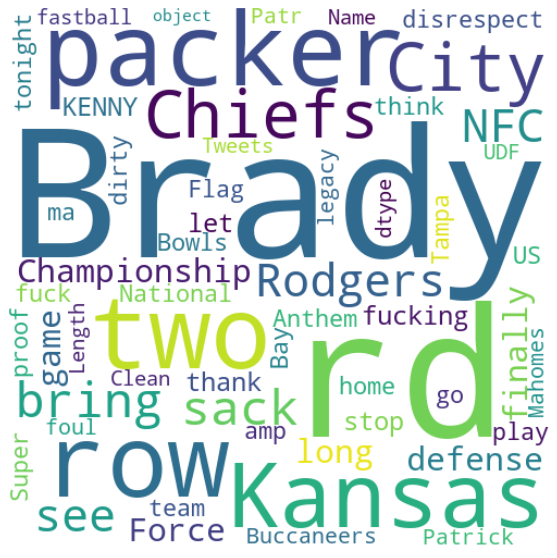

In [96]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(game_low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

### C. Team Word Clouds

#### Kansas City Chiefs

In [97]:
chiefs_tweets_string = ' '.join(chiefs_clean_tweets)
chiefs_tweets_fd = FreqDist(chiefs_tweets_string.split())
chiefs_tweets_fd.most_common(20)

[('Mahomes', 6888),
 ('Chiefs', 4332),
 ('Patrick', 4260),
 ('…', 3066),
 ('Brady', 1914),
 ('Kansas', 1795),
 ('City', 1759),
 ('go', 1600),
 ('vs', 1586),
 ('Allen', 1529),
 ('Josh', 1369),
 ('KC', 1189),
 ('game', 1117),
 ('Super', 1025),
 ('good', 1007),
 ('get', 1003),
 ('Bowl', 936),
 ('bill', 858),
 ('win', 844),
 ('play', 841)]

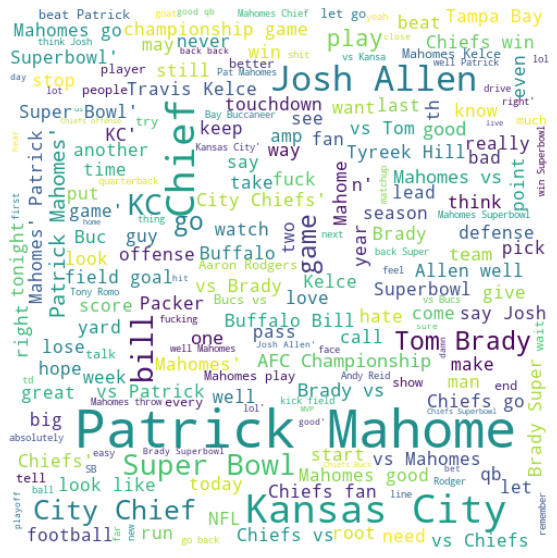

In [98]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(chiefs_clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [99]:
#top polarity values
chiefs_assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
3829,LOL! I just said to my husband - “They’re STI...,1.0,0.7,"[([lol, !], 1.0, 0.7, None)]","lol say husband "" still ' Chiefs ' "" \n co..."
13116,Patrick Mahomes has been wonderful to watch.,1.0,1.0,"[([wonderful], 1.0, 1.0, None)]",Patrick Mahomes wonderful watch
2646,Patrick Mahomes being the best quarterback in...,1.0,0.3,"[([best], 1.0, 0.3, None)]",Patrick Mahomes good quarterback world age ...
10523,Kansas MF City !!! Patrick Maf Mahomes !!! Is ...,1.0,0.3,"[([best], 1.0, 0.3, None)]",Kansas MF City Patrick Maf Mahomes good qu...
5805,The Kansas City Chiefs are the best there is ...,1.0,0.3,"[([best], 1.0, 0.3, None)]",Kansas City Chiefs good ’ say
12319,Can’t wait for my Chiefs to win it all!!!!,1.0,0.4,"[([win, !, !, !, !], 1.0, 0.4, None)]",wait Chiefs win
3506,best QBs to ever play in the NFL: 1. Aaron Rod...,1.0,0.3,"[([best], 1.0, 0.3, None)]",good QBs ever play NFL Aaron Rodgers \n Pat...
7188,Meet two of Chiefs quarterback Patrick Mahomes...,1.0,0.3,"[([best], 1.0, 0.3, None)]",meet two Chiefs quarterback Patrick Mahomes ’ ...
7190,"Oh look, Brady vs Mahomes...an absolutely PERF...",1.0,1.0,"[([absolutely, perfect], 1.0, 1.0, None)]",oh look Brady vs Mahomesan absolutely perfect ...
5765,Mahomes is the best QB we’ve seen come into th...,1.0,0.3,"[([best], 1.0, 0.3, None)]",Mahomes good qb see come NFL ever change mind


In [100]:
chiefs_top_polar = chiefs_assessments_df.loc[chiefs_assessments_df['Polarity'] >= 0.01]
chiefs_top_tweets_string = ' '.join(chiefs_top_polar["UDF Clean Tweets"])
chiefs_top_tweets_fd = FreqDist(chiefs_top_tweets_string.split())
chiefs_top_tweets_fd.most_common(20)

[('Mahomes', 3184),
 ('Patrick', 1954),
 ('Chiefs', 1932),
 ('…', 1637),
 ('Brady', 980),
 ('Super', 958),
 ('good', 954),
 ('Bowl', 865),
 ('vs', 804),
 ('Kansas', 798),
 ('City', 776),
 ('go', 774),
 ('win', 754),
 ('Allen', 753),
 ('Josh', 682),
 ('KC', 529),
 ('Tom', 474),
 ('well', 461),
 ('get', 435),
 ('bill', 397)]

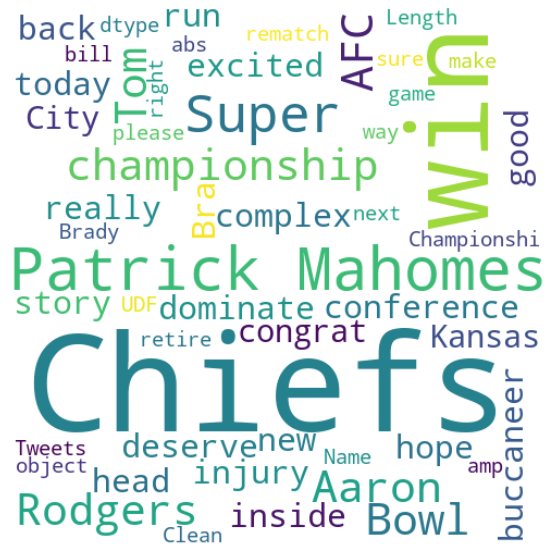

In [101]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(chiefs_top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [102]:
#lowest polarity values
chiefs_assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
8497,How is nobody covering Kelce? worst in league ...,-1.0,1.000000,"[([worst], -1.0, 1.0, None)]",nobody cover Kelce worst league vs te
2090,Patrick Mahomes is the fucking insane,-1.0,1.000000,"[([fucking, insane], -1.0, 1.0, None)]",Patrick Mahomes fucking insane
4845,Sick! go KC!,-1.0,0.857143,"[([sick, !, !], -1.0, 0.8571428571428571, None)]",Sick go KC
6671,These niggas are weak !!!! We the Kansas City ...,-1.0,0.625000,"[([weak, !, !, !, !, !, !, !], -1.0, 0.625, No...",nigga weak Kansas City chief bitch
6665,A Buccaneers &amp; Chiefs how boring.,-1.0,1.000000,"[([boring], -1.0, 1.0, None)]",Buccaneers amp chief boring
12211,Patrick Mahomes Got a NASTY runny Nose 🤮🤢,-1.0,1.000000,"[([nasty], -1.0, 1.0, None)]",Patrick Mahomes get nasty runny nose 🤮 🤢
11061,"Kansas City, you play the worst in-stadium mus...",-1.0,1.000000,"[([worst, !], -1.0, 1.0, None)]",Kansas City play bad instadium music ever
6580,Terrible time to throw and interception Josh A...,-1.0,1.000000,"[([terrible], -1.0, 1.0, None)]",terrible time throw interception Josh Allen Ch...
2542,Kelce is going crazy!!!!,-1.0,0.900000,"[([crazy, !, !, !, !], -1.0, 0.9, None)]",Kelce go crazy
2631,I just had the terrible realization that passi...,-1.0,1.000000,"[([terrible], -1.0, 1.0, None)]",terrible realization pass Patrick Mahomes Jama...


In [103]:
chiefs_low_polar = chiefs_assessments_df.loc[chiefs_assessments_df['Polarity'] <= -0.01]
chiefs_low_tweets_string = ' '.join(chiefs_low_polar["UDF Clean Tweets"])
chiefs_low_tweets_fd = FreqDist(chiefs_low_tweets_string.split())
chiefs_low_tweets_fd.most_common(20)

[('Mahomes', 1026),
 ('Chiefs', 785),
 ('game', 676),
 ('…', 657),
 ('Patrick', 626),
 ('Kansas', 326),
 ('City', 319),
 ('KC', 274),
 ('Allen', 266),
 ('go', 263),
 ('Brady', 229),
 ('get', 227),
 ('Josh', 226),
 ('AFC', 197),
 ('bill', 192),
 ('play', 191),
 ('vs', 178),
 ('’', 177),
 ('like', 176),
 ('Buffalo', 169)]

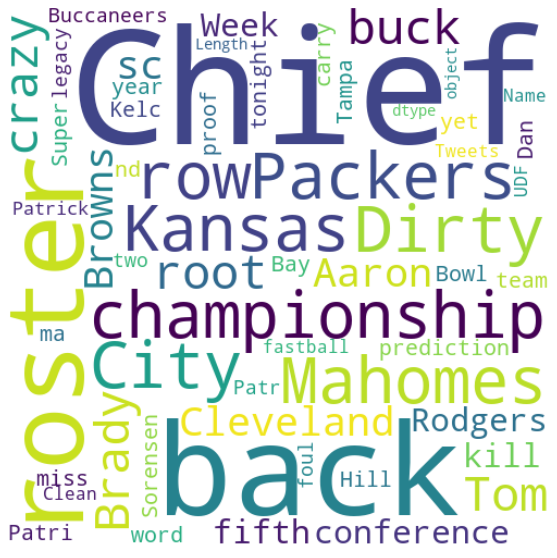

In [104]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(chiefs_low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#### Tampa Bay Buccaneers

In [105]:
bucs_tweets_string = ' '.join(bucs_clean_tweets)
bucs_tweets_fd = FreqDist(bucs_tweets_string.split())
bucs_tweets_fd.most_common(20)

[('Brady', 11023),
 ('Bucs', 8668),
 ('Tom', 6740),
 ('…', 3719),
 ('go', 2833),
 ('get', 2422),
 ('vs', 1851),
 ('game', 1746),
 ('Mahomes', 1726),
 ('Packers', 1660),
 ('win', 1604),
 ('Super', 1351),
 ('play', 1338),
 ('Bowl', 1281),
 ('Rodgers', 1263),
 ('like', 1181),
 ('’', 1154),
 ('buccaneer', 1118),
 ('defense', 1062),
 ('Bay', 1026)]

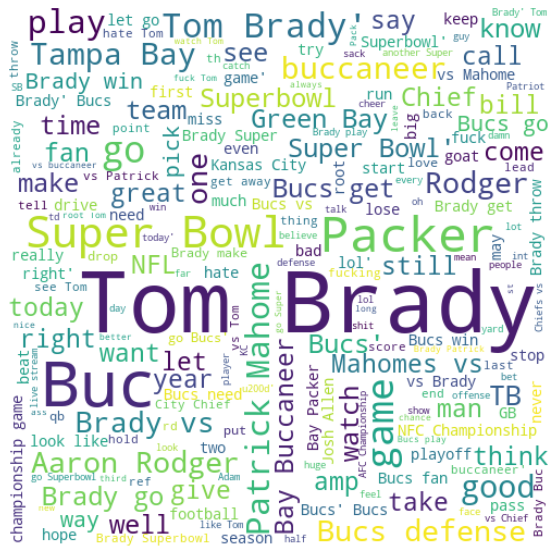

In [106]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(bucs_clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [107]:
#top polarity values
bucs_assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
9277,Tom Brady doing what Bucs QBs do best... throw...,1.0,0.30,"[([best], 1.0, 0.3, None)]",Tom Brady Bucs qb good throw interception
15077,This 4th quarter is about to be legendary One ...,1.0,1.00,"[([legendary], 1.0, 1.0, None)]",th quarter legendary one quarter decide NFC ch...
1800,I guess signing the best cold-weather quarter...,1.0,0.30,"[([best], 1.0, 0.3, None)]",guess sign good coldweather quarterback allt...
7037,Murphy Bunting is the best corner on the Bucca...,1.0,0.30,"[([best], 1.0, 0.3, None)]",Murphy Bunting good corner buccaneer
1813,Best of luck to El Paso legend &amp; the as t...,1.0,0.30,"[([best], 1.0, 0.3, None)]",good luck El Paso legend amp battle lead Tom...
20305,2 take aways TB is the best QB of his generat...,1.0,0.30,"[([best], 1.0, 0.3, None)]",take away TB good qb generation AR shot tit...
3809,Good stop Bucs!!,1.0,0.60,"[([good, !, !], 1.0, 0.6000000000000001, None)]",good stop Bucs
13169,Tom Brady is the greatest NFL player of all ti...,1.0,1.00,"[([greatest], 1.0, 1.0, None)]",Tom Brady great NFL player time 🤷 ‍
3818,Great D by my Bucs!,1.0,0.75,"[([great, !], 1.0, 0.75, None)]",great Bucs
15037,"Kasie, as a Ravens fan I can’t in good faith ...",1.0,0.60,"[([good, !, !, !], 1.0, 0.6000000000000001, No...",Kasie Ravens fan good faith root Bucs Go Pac...


In [108]:
bucs_top_polar = bucs_assessments_df.loc[bucs_assessments_df['Polarity'] >= 0.01]
bucs_top_tweets_string = ' '.join(bucs_top_polar["UDF Clean Tweets"])
bucs_top_tweets_fd = FreqDist(bucs_top_tweets_string.split())
bucs_top_tweets_fd.most_common(20)

[('Brady', 4732),
 ('Bucs', 3238),
 ('Tom', 2897),
 ('…', 1948),
 ('win', 1464),
 ('go', 1249),
 ('Super', 1247),
 ('Bowl', 1161),
 ('get', 963),
 ('vs', 880),
 ('Mahomes', 877),
 ('good', 860),
 ('Packers', 643),
 ('play', 573),
 ('Rodgers', 559),
 ('game', 519),
 ('’', 498),
 ('like', 496),
 ('first', 473),
 ('buccaneer', 466)]

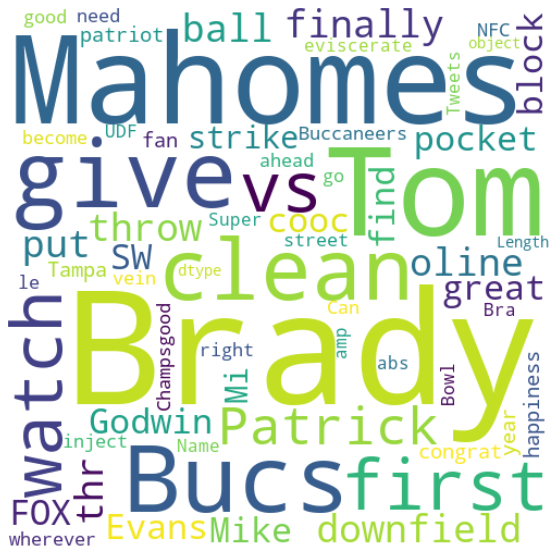

In [109]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(bucs_top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [110]:
#lowest polarity values
bucs_assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
10706,This Bucs defense is absolutely awful,-1.0,1.0,"[([absolutely, awful], -1.0, 1.0, None)]",Bucs defense absolutely awful
11331,Come on packers!!! I want to see a sad Tom Bra...,-1.0,1.0,"[([sad, !, !, !, !, !, !], -1.0, 1.0, None)]",come packer want see sad Tom Brady
19749,I think the worst thing about this is I'm goin...,-1.0,1.0,"[([worst], -1.0, 1.0, None)]",think bad thing go root Buccaneers 🤣
1607,Bucs defense looks menacing today,-1.0,1.0,"[([menacing], -1.0, 1.0, None)]",Bucs defense look menacing today
13121,I just hate Brady‼‼‼ Let’s go packers!!,-1.0,0.9,"[([hate, !, !], -1.0, 0.9, None)]",hate brady‼‼‼ let ’s go packer
9637,Packers looking dangerous now! Brady gets pick...,-1.0,0.9,"[([dangerous, !, !, !], -1.0, 0.9, None)]",packer look dangerous Brady get pick via
9675,WHY would Brady take that Risk into Dbl covera...,-1.0,1.0,"[([horrible], -1.0, 1.0, None)]",would Brady take risk Dbl coverage horrible ...
9704,"for all the credit thrown at Brady, Packers s...",-1.0,1.0,"[([worst], -1.0, 1.0, None)]",credit throw Brady Packers pick King st TD b...
15356,These Bucs WR drops are absolutely horrible....,-1.0,1.0,"[([absolutely, horrible], -1.0, 1.0, None)]",Bucs WR drop absolutely horrible
9779,I agree B! I fucking hate Tom Brady!,-1.0,0.9,"[([fucking, hate, !], -1.0, 0.9, None)]",agree b fucking hate Tom Brady


In [111]:
bucs_low_polar = bucs_assessments_df.loc[bucs_assessments_df['Polarity'] <= -0.01]
bucs_low_tweets_string = ' '.join(bucs_low_polar["UDF Clean Tweets"])
bucs_low_tweets_fd = FreqDist(bucs_low_tweets_string.split())
bucs_low_tweets_fd.most_common(20)

[('Brady', 2243),
 ('Bucs', 1870),
 ('Tom', 1401),
 ('game', 1139),
 ('…', 867),
 ('get', 611),
 ('go', 587),
 ('Packers', 522),
 ('Bay', 406),
 ('hate', 319),
 ('play', 309),
 ('’', 294),
 ('Rodgers', 278),
 ('vs', 267),
 ('Green', 263),
 ('defense', 253),
 ('packer', 249),
 ('like', 217),
 ('fan', 217),
 ('bad', 211)]

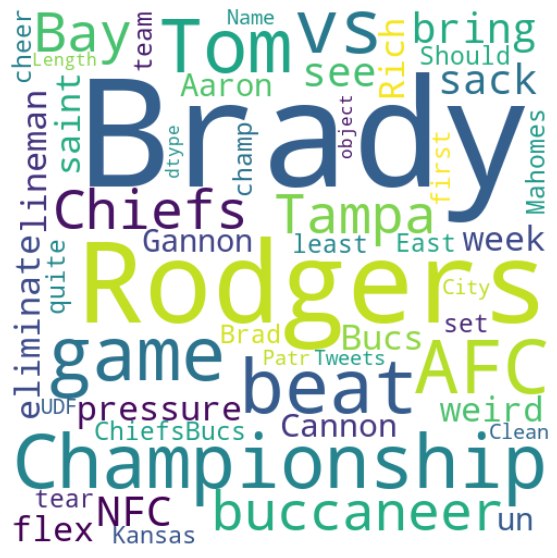

In [112]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(bucs_low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

## 12. DBSCAN Clustering

### A. Full Tweets

In [113]:
vectorizer = TfidfVectorizer(min_df=10) #min number of tweets (min doc freq)
features = vectorizer.fit_transform(full_clean_tweets) #full dataset
type(features)

scipy.sparse.csr.csr_matrix

In [114]:
features.shape

(125772, 4080)

In [115]:
#convert matrix to numpy dense matrix
features = features.todense()

In [116]:
# make a model
model = DBSCAN(eps=0.5, min_samples=40, n_jobs= -1) 


In [117]:
model.fit(features)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=-1, p=None)

In [118]:
labels = model.labels_ #get model labels

In [119]:
no_clusters = len(np.unique(labels)) #number of unique labels
no_noise = np.sum(np.array(labels) == -1, axis=0) # number of outliers OR model.labels_[model.labels_ == -1].size 


print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)



Estimated no. of clusters: 36
Estimated no. of noise points: 121135


In [120]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(features, labels))

Silhouette Coefficient: -0.257


In [121]:
cluster0_tweets = np.array(full_clean_tweets)[labels == 0] #get tweets in cluster = 0
len(cluster0_tweets)

171

In [122]:
cluster0_tweets

array(['  packer', '  packer', '  packer', '  packer', '  packer',
       '  packer', '  packer   rack', '  packer', 'packer',
       '  voting packer', '  packer', 'packer', 'packer', '  packer',
       '  packer', 'packer', 'strappin packer', 'packer', 'packer',
       'jennifer introduce packer shareholder', 'packer 🤦', '  packer',
       '  packer', '  packer', '  L packer', 'packer 🤞', '  packer',
       '   packer', '  packer  ', 'TOUCHDOOOOWNNNN packer', '  packer',
       'TOUCHDOWNNNNNNNNNNNNNN packer', 'TOUCHDOOOOWN packer', '  packer',
       'packer', 'packer', '  retract retraction packer', 'packer',
       '  packer 🤢', 'packer 🧀', '  packer', 'packer poundin peel',
       'packer', '  packer', '  packer', 'Odell packer', '  packer',
       '  packer', '   packer 🤦 \u200d 🤦 \u200d', 'packer',
       'warehouse Pickers    packer', '  packer', '  packer', 'packer',
       '  packer', 'packer', '  packer', 'feck packer', '  packer',
       '  packer', '  packer', '  Ew packe

In [123]:
wordcount0 = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_tweets)))
print('Cluster 1 contains',len(wordcount0),'words.')

Cluster 1 contains 62 words.


In [124]:
wordcount0.most_common(15)

[('packer', 171),
 ('🧀', 5),
 ('🥵', 5),
 ('🤦', 4),
 ('\u200d', 4),
 ('🤞', 3),
 ('’', 3),
 ('F', 2),
 ('rack', 1),
 ('voting', 1),
 ('strappin', 1),
 ('jennifer', 1),
 ('introduce', 1),
 ('shareholder', 1),
 ('L', 1)]

In [125]:
cluster_tweets = [] #tokenize words in each cluster and compute the counts for each token 

for i in range(0, no_clusters):
    cluster_tweets.append(nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(np.array(full_clean_tweets)[labels == i]))))

In [126]:
for i in range(0, len(cluster_tweets)):
    print('Cluster', i+1,'-', cluster_tweets[i].most_common(10), '\n') #most common words in each cluster
    

Cluster 1 - [('packer', 171), ('🧀', 5), ('🥵', 5), ('🤦', 4), ('\u200d', 4), ('🤞', 3), ('’', 3), ('F', 2), ('rack', 1), ('voting', 1)] 

Cluster 2 - [('Bucs', 106), ('bucs', 19), ('BUCS', 14), ('sellin', 2), ('SELLLINNNGGGGGG', 2), ('wheeew', 1), ('Buccos', 1), ('relentless', 1), ('sike', 1), ('EATIN', 1)] 

Cluster 3 - [('go', 676), ('let', 350), ('’', 215), ('s', 201), ('packer', 157), ('Bucs', 97), ('GO', 45), ('Go', 35), ('Packers', 33), ('bucs', 30)] 

Cluster 4 - [('Tom', 102), ('Brady', 96), ('TOM', 12), ('BRADY', 12), ('brady', 12), ('go', 9), ('’', 8), ('tom', 7), ('\u200d', 3), ('sackado', 2)] 

Cluster 5 - [('say', 70), ('``', 8), ('’', 3), ('Josh', 3), ('Allen', 3), ('louder', 3), ('tore', 2), ('groin', 2), ('\u200d', 2), ('NADA', 2)] 

Cluster 6 - [('fuck', 107), ('FUCK', 39), ('Fuck', 33), ('Allen', 30), ('Brady', 24), ('Josh', 24), ('Tom', 23), ('bill', 16), ('josh', 13), ('tom', 10)] 

Cluster 7 - [('’', 63), ('…', 21), ('←', 19), ('🤣', 17), ('\u200d', 13), ('u', 10), ('e

### B. Game Tweets

In [127]:
vectorizer = TfidfVectorizer(min_df=10) #min number of tweets (min doc freq)
features = vectorizer.fit_transform(clean_tweets) #game dataset
type(features)

scipy.sparse.csr.csr_matrix

In [128]:
features.shape

(63598, 2843)

In [129]:
#convert matrix to numpy dense matrix
features = features.todense()

In [130]:
# make a model
model = DBSCAN(eps=0.5, min_samples=40, n_jobs= -1) 

In [131]:
model.fit(features)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=-1, p=None)

In [132]:
labels = model.labels_

In [133]:
no_clusters = len(np.unique(labels)) #number of unique labels
no_noise = np.sum(np.array(labels) == -1, axis=0) # number of outliers OR model.labels_[model.labels_ == -1].size 


print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)



Estimated no. of clusters: 9
Estimated no. of noise points: 63032


In [134]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(features, labels))

Silhouette Coefficient: -0.067


In [135]:
cluster0_tweets = np.array(clean_tweets)[labels == 0] #get tweets in cluster = 0
len(cluster0_tweets)

115

In [136]:
cluster0_tweets

array(['Bucs', '  Bucs', 'Bucs  ', '  Bucs', 'Bucs   wheeew', '  Bucs',
       '  Bucs', '  Bucs', '  Buccos Bucs', '  Bucs', '  Bucs', 'Bucs',
       'Bucs', '   Bucs', 'mmm Bucs', '  Bucs', '  Bucs', 'Bucs',
       '   Bucs', '  Bucs', '  Lolmaybe Bucs', 'Bucs', 'Fuc Bucs',
       '  Bucs', '     Bucs', 'mannn Bucs goon', '  Bucs',
       'Gwan Bucs \u200d\u200d\u200d', '  Bucs', '  Bucs', '  Bucs',
       'Hon Bucs', '  Bucs', 'Bucs Bucs Bucs', '  Bucs',
       'Bucs erinnern bissl rapid mit Savicevic', '   Bucs', '  Bucs',
       'Bucs', '  Bucs', '  Bucs', '  Bucs   oder wattt', '   Bucs',
       '  Bucs', '  Bucs', 'PickGo Bucs', 'Bucs cheatin', 'Bucs',
       'Bucs D tuff', "Cheatin ' Bucs", 'Bucs', 'Bucs Babbbbbbbbyyyyyy',
       '🦌 \u200d Bucs', 'Bucs  ', '  Bucs', 'Bucs', 'Bucs', '  Bucs',
       '   Bucs', 'Bucs', 'Bucs chokin', 'Bucs teeter', '  Bucs maniac',
       'Bucs', 'Bucs safetie', 'Bucs y’', 'Bucs backer', 'Bucs sellin',
       '  Bucs', 'damnit Bucs', 'Bucs', '  B

In [137]:
wordcount0 = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_tweets)))
print('Cluster 1 contains',len(wordcount0),'words.')

Cluster 1 contains 68 words.


In [138]:
wordcount0.most_common(15)

[('Bucs', 119),
 ('D', 2),
 ('sellin', 2),
 ('SELLLINNNGGGGGG', 2),
 ('wheeew', 1),
 ('Buccos', 1),
 ('mmm', 1),
 ('Lolmaybe', 1),
 ('Fuc', 1),
 ('mannn', 1),
 ('goon', 1),
 ('Gwan', 1),
 ('\u200d\u200d\u200d', 1),
 ('Hon', 1),
 ('erinnern', 1)]

In [139]:
cluster_tweets = [] #tokenize words in each cluster and compute the counts for each token 

for i in range(0, no_clusters):
    cluster_tweets.append(nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(np.array(clean_tweets)[labels == i]))))

In [140]:
for i in range(0, len(cluster_tweets)):
    print('Cluster', i+1,'-', cluster_tweets[i].most_common(10), '\n') #most common words in each cluster
    

Cluster 1 - [('Bucs', 119), ('D', 2), ('sellin', 2), ('SELLLINNNGGGGGG', 2), ('wheeew', 1), ('Buccos', 1), ('mmm', 1), ('Lolmaybe', 1), ('Fuc', 1), ('mannn', 1)] 

Cluster 2 - [('Tom', 108), ('Brady', 107), ('go', 9), ('’', 8), ('\u200d', 4), ('🤷', 3), ('brady', 2), ('sackado', 2), ('``', 2), ('poetry', 2)] 

Cluster 3 - [('go', 66), ('Bucs', 59), ('\u200d', 3), ('Go', 3), ('🤣', 3), ('🥳', 2), ('Fitzpatrick', 2), ('sportsball', 1), ('🥍', 1), ('🤙', 1)] 

Cluster 4 - [('touchdown', 46), ('🥳', 4), ('Touchdown', 2), ('¡', 2), ('Woot', 1), ('needed', 1), ('tonyon', 1), ('Packersfuck', 1), ('convinced', 1), ('TKELCE', 1)] 

Cluster 5 - [('let', 45), ('go', 45), ('Bucs', 38), ('’', 36), ('s', 36), ('Brady', 6), ('\u200d', 1), ('defense', 1), ('Yessirrr', 1), ('Tampaaaaa', 1)] 

Cluster 6 - [('win', 48), ('Bucs', 19), ('’', 3), ('bucs', 2), ('Yakno', 1), ('Q', 1), ('h', 1), ('gnite', 1), ('WFT', 1), ('halfthey', 1)] 

Cluster 7 - [('Brady', 80), ('vs', 79), ('Mahomes', 74), ('Superbowl', 16), (

In [141]:
#could use function similar to the one below to try and find "ideal" eps and minpts values

# eps = [0.2, 0.5, 0.75, 1.00]
# minpts = [20, 25, 30, 40]

# for x in eps:
#     for y in minpts:
#         model = DBSCAN(eps=x, min_samples=y, n_jobs= -1)
#         model.fit(features)
#         labels = model.labels_
#         no_clusters = len(np.unique(labels)) #number of unique labels
#         no_noise = np.sum(np.array(labels) == -1, axis=0)
#         print('Epsilon (eps): %0.1f' % x)
#         print('Minimum samples (minPts): %d' % y)
#         print('Estimated no. of clusters: %d' % no_clusters)
#         print('Estimated no. of noise points: %d' % no_noise)
#         print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(features, labels))
#         print('\n')

In [142]:
#%history

In [143]:
#client.close()

# Resources

1. Import data from MongoDB: https://stackoverflow.com/questions/16249736/how-to-import-data-from-mongodb-to-pandas
2. Remove emoji's: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b 
2. Reindex dataframe: https://stackoverflow.com/questions/28885073/reindexing-after-pandas-drop-duplicates
3. Multidict: https://medium.com/analytics-vidhya/mapping-keys-to-multiple-values-in-a-dictionary-b5022de9dd0e
4. Textblob: https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
5. spaCy: https://spacy.io/
6. Word cloud: https://www.geeksforgeeks.org/generating-word-cloud-python/
7. DBSCAN model: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan
8. Estimate clusters and noise points: https://www.machinecurve.com/index.php/2020/12/09/performing-dbscan-clustering-with-python-and-scikit-learn/
9. Silhouette score: https://shritam.medium.com/how-dbscan-algorithm-works-2b5bef80fb3
10. TF-IDF: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html